In [151]:
import torch, torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from torchvision import datasets, transforms

# This emsures that our results are predictable
torch.manual_seed(5)
np.random.seed(5)

In [152]:
# Hyperparameters
mini_batch_size = 128 # If None, do batch gradient descent
n_epochs = 1
layers = [28*28, 128, 10]
data_path='.'
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

def t(test):
    try: print(test.shape)
    except: print(test)

In [153]:
# Dataloaders
transform = transforms.Compose([
            #  transforms.Grayscale(), # Dataset is already grayscale
             transforms.Resize((28,28)),
             transforms.ToTensor(),
             transforms.Normalize((0,), (1,))
])
train_set = datasets.FashionMNIST(data_path, train=True, download=True, transform=transform)
test_set = datasets.FashionMNIST(data_path, train=False, download=True, transform=transform)
if False:
    train_set = utils.data_subset(train_set, 60)
    test_set = utils.data_subset(test_set, 10)
    
train_load = DataLoader(train_set, batch_size=mini_batch_size, shuffle=True, drop_last=False)
test_load = DataLoader(test_set, batch_size=128, shuffle=True, drop_last=False)
# print(train_load.dataset.data.shape) # .dataset.data returns a tensor - torch.tensor(list(train_load)) does NOT work
# print(test_load.dataset.data.shape)

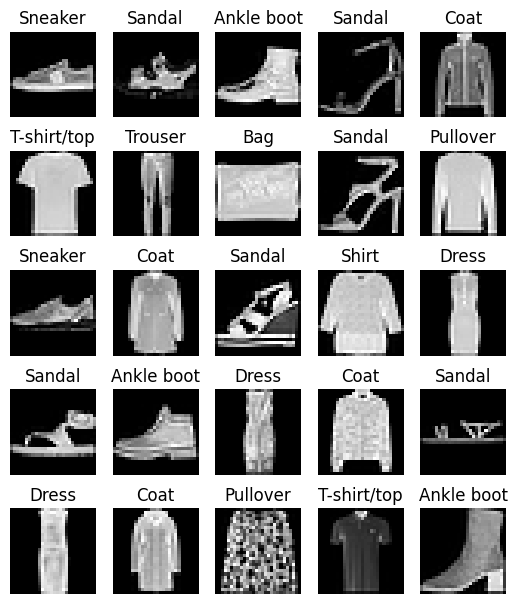

In [154]:
train_iter = iter(train_load)
train_images, train_labels = zip(*datasets.FashionMNIST(data_path, train=True, download=True))
train_images = np.asarray([np.array(img) for img in train_images], dtype=np.float32)
train_labels = np.asarray(train_labels, dtype=np.int64)
# print(train_images.shape)
img_indices = np.array([np.random.randint(0, len(train_images)) for i in range(25)])
fig, axes = plt.subplots(5, 5)
for n, i in enumerate(img_indices):
    axes[n//5, n%5].set_title(class_names[train_labels[i]])
    img = train_images[i]
    axes[n//5, n%5].axis('off')
    axes[n//5, n%5].imshow(img, cmap='gray')
plt.subplots_adjust(bottom=0, top=1.2)

In [155]:
class CNN(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.convolutions = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 32, 3, padding=1),
            nn.ReLU(),
        )
        self.fully_connected = nn.Sequential(
            nn.Flatten(),
            nn.Linear(int((layers[0])*32)//4, layers[1]),
            nn.ReLU(),
            nn.Linear(layers[1], layers[2]),
            nn.ReLU()
        )
    
    def forward(self, inputs):
        x = self.convolutions(inputs)
        x = self.fully_connected(x)
        # utils.reset(self.stack)
        return x

model = CNN()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3, betas=(0.9, 0.999))
loss_fn = nn.CrossEntropyLoss()

In [156]:
def train(model, train_iter=train_iter, optimizer=optimizer, loss=loss_fn, ps=50):
    for i, (data, targets) in enumerate(train_iter):
        if ps and i==0: print(data.shape)
        # data = spikegen.rate(data=data, num_steps=n_steps, gain=spike_rate_white)
        model.train()
        # outputs = []
        loss_val = torch.tensor(0, dtype=float)
        # for step in range(n_steps):
            # outputs.append(model(data[step])[0])
            # loss += loss_fn(outputs[step], targets)
        outputs = model.forward(data)
        loss_val = loss(outputs, targets)
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        x = loss_val.item()
        # utils.reset(model.stack)
        model.eval()
        with torch.no_grad():
            if ps and i % ps == 0:
                print(f"Loss is {loss}")
                predicted = outputs.max(1)[1]
                # if i==0: 
                    # print(outputs.shape, end="; ")
                    # print(outputs[0:5, 0, 0]) # First 5 steps of output of 1 sample and 1 output neuron
                    # print(predicted[0:6])
                correct = (predicted == targets).sum().item()
                accuracy = correct/len(targets)
                print(f"Train accuracy is {accuracy*100:.3f}%")

In [157]:
train(model)

torch.Size([128, 1, 28, 28])
Loss is CrossEntropyLoss()
Train accuracy is 17.969%
Loss is CrossEntropyLoss()
Train accuracy is 71.094%
Loss is CrossEntropyLoss()
Train accuracy is 80.469%
Loss is CrossEntropyLoss()
Train accuracy is 79.688%
Loss is CrossEntropyLoss()
Train accuracy is 82.031%
Loss is CrossEntropyLoss()
Train accuracy is 78.125%
Loss is CrossEntropyLoss()
Train accuracy is 80.469%
Loss is CrossEntropyLoss()
Train accuracy is 85.156%
Loss is CrossEntropyLoss()
Train accuracy is 78.906%
Loss is CrossEntropyLoss()
Train accuracy is 87.500%


In [158]:
def accuracy(model, test):
    model.eval()
    with torch.no_grad():
        count = 0
        correct = 0
        for data, targets in iter(test):
            # data = spikegen.rate(data=data, num_steps=n_steps, gain=spike_rate_white)
            outputs=[]
            # for step in range(n_steps):
            #     spk, mem = model(data[step])
            #     outputs.append(spk)
            #     utils.reset(model.stack)
            outputs = model.forward(data)
            predicted = outputs.max(1)[1]
            count += len(targets)
            correct += (predicted == targets).sum().item()
        accuracy = correct/count
        return accuracy

In [159]:
acc_test = (accuracy(model, test_load))
acc_train = (accuracy(model, train_load))
print(
    f'''
    Accuracy on test dataset is {acc_test*100: .5f}%.
    Accuracy on train datset is {acc_train*100: .5f}%.
    '''
)


    Accuracy on test dataset is  80.53000%.
    Accuracy on train datset is  81.06667%.
    
